In [2]:
import sys
sys.path.append('..')
sys.path.append('../src')
sys.path.append('../data')

import torch
import plotly.express as px
import src.nanda_plot
from src.model import WrapHookedTransformer
from src.nanda_plot import imshow_reversed, imshow
import pandas as pd
import numpy as np

from src.result_analyzer import ResultAnalyzer

%load_ext autoreload
%autoreload 2

In [28]:
result.data["mem"]["attn_out_by_pos"].keys()

AttributeError: 'list' object has no attribute 'keys'

In [27]:
result.data["mem"].keys()

dict_keys(['attn_head_out', 'mlp_out', 'attn_out_by_pos', 'premise', 'clean_probs_mem', 'clean_probs_cp'])

## Generate the CSV file

In [67]:
# FILE_NAME = "gpt2_full_result"
FILE_NAME = "gpt2_result_len_16"
# FILE_NAME = "opt-125m_full_result_ablation"
result = ResultAnalyzer(f"{FILE_NAME}.pt")

In [68]:
result.process_neg_top_component_per_prompt()
result.process_pos_top_component_per_prompt()

,prompt,top1_attention_head_idx,top1_attention_head_val,top2_attention_head_idx,top2_attention_head_val,top3_attention_head_idx,top3_attention_head_val,top1_component_mlp_idx,top1_component_mlp_val,top2_component_mlp_idx,top2_component_mlp_val,top3_component_mlp_idx,top3_component_mlp_val,top1_component_attn_idx,top1_component_attn_val,top2_component_attn_idx,top2_component_attn_val,top3_component_attn_idx,top3_component_attn_val
0,Windows 3.1 is developed byoton Windows 3.1 is...,L0H10,0.022191,L0H8,0.019107,L0H1,0.018886,L6P15,0.017615,L0P2,0.016387,L0P5,"[0.017614850774407387, 0.01638667657971382, 0....",L0P11,0.018348,L11P15,0.016674,L8P15,0.013550
1,Windows Embedded Compact is developed by Quin ...,L0H6,0.089182,L8H9,0.074243,L0H8,0.073943,L0P1,0.066742,L6P15,0.037717,L0P7,"[0.06674239784479141, 0.03771665692329407, 0.0...",L11P15,0.078884,L0P15,0.074041,L8P15,0.052797
2,"Windows Me, a product developed by assembled W...",L8H9,0.108905,L1H10,0.096165,L0H10,0.095985,L0P10,0.098203,L0P1,0.086910,L0P11,"[0.09820276498794556, 0.08691006898880005, 0.0...",L8P15,0.110211,L0P4,0.100481,L0P9,0.097599
3,Game Boy Advance is a product oflain Game Boy ...,L0H8,0.172749,L0H10,0.166012,L0H7,0.146012,L6P15,0.159485,L0P14,0.123110,L8P15,"[0.15948526561260223, 0.12311021983623505, 0.1...",L0P15,0.181461,L0P5,0.162270,L8P15,0.138392
4,"iPhone XS Max, produced byMet iPhone XS Max, p...",L0H1,0.067397,L11H0,0.060621,L10H0,0.048214,L8P15,0.070397,L0P15,0.052464,L9P15,"[0.07039736211299896, 0.052463989704847336, 0....",L0P15,0.084004,L8P15,0.079410,L11P15,0.071748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,"Windows 3.1, developed by popul Windows 3.1, d...",L8H9,0.040186,L0H10,0.040151,L0H8,0.031156,L0P10,0.031437,L0P7,0.030511,L0P2,"[0.03143707290291786, 0.03051147051155567, 0.0...",L8P15,0.038524,L0P11,0.033929,L11P15,0.029871
437,Windows 9x is a product ofEVA Windows 9x is a ...,L0H10,0.165934,L5H1,0.155158,L0H8,0.135871,L0P15,0.161891,L0P1,0.135442,L8P15,"[0.16189099848270416, 0.13544225692749023, 0.1...",L0P15,0.168693,L8P15,0.159514,L0P12,0.122819
438,Yonsei University is based inAl Yonsei Univers...,L0H8,0.048431,L0H10,0.038280,L8H9,0.037231,L0P2,0.036909,L8P15,0.035929,L7P15,"[0.03690892457962036, 0.03592894598841667, 0.0...",L8P15,0.041855,L0P2,0.036888,L11P15,0.035062
439,Uganda belongs to the continent of Breast Ugan...,L0H8,0.090231,L5H9,0.065091,L4H7,0.060649,L0P15,0.090310,L0P10,0.066714,L8P15,"[0.09030994772911072, 0.06671403348445892, 0.0...",L0P15,0.108377,L0P9,0.083133,L11P15,0.060680


In [69]:
result.process_data("mem", "mlp_out")
result.process_data("mem", "attn_out_by_pos")
result.process_data("mem", "attn_head_out")
result.process_data("cp", "mlp_out")
result.process_data("cp", "attn_out_by_pos")
result.process_data("cp", "attn_head_out")


,id,mean,std,positive,negative,p-value,kl-mean,kl-std
0,L0H0,-0.212558,0.337686,35,118,9.955101e-13,0.019457,0.029409
1,L0H1,-1.046290,0.829408,16,137,2.252934e-33,0.394307,0.450652
2,L0H2,-0.043987,0.428206,69,84,2.057988e-01,0.027282,0.036834
3,L0H3,0.277424,0.719233,103,50,4.262106e-06,0.056516,0.128629
4,L0H4,0.338467,0.648537,113,40,1.370968e-09,0.036749,0.039287
...,...,...,...,...,...,...,...,...
139,L11H7,0.061208,0.194937,99,54,1.530052e-04,0.008254,0.013411
140,L11H8,0.030512,0.155251,87,66,1.622248e-02,0.011042,0.006565
141,L11H9,0.378823,0.471046,120,33,2.877384e-18,0.021956,0.024127
142,L11H10,-0.363095,0.288306,14,139,2.630729e-33,0.043815,0.065756


In [52]:
model = WrapHookedTransformer.from_pretrained("gpt2")
# result.compute_correlation_pos(model, "attn_head_out")
# result.compute_correlation_pos(model, "mlp_out")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [74]:
model.predict("The native language of Nicholas I of Russia is")

(tensor([14.2288]), [' Russian'])

## PLOT

In [70]:
import pandas as pd

# Load a sample from each CSV file to understand their structure
csv_files = [
    f"{FILE_NAME}_cp_attn_head_out.csv",
    f"{FILE_NAME}_cp_attn_out_by_pos.csv",
    f"{FILE_NAME}_cp_mlp_out.csv",
    f"{FILE_NAME}_mem_attn_head_out.csv",
    f"{FILE_NAME}_mem_attn_out_by_pos.csv",
    f"{FILE_NAME}_mem_mlp_out.csv",
]

sample_data = {}

for file in csv_files:
    sample_data[file] = pd.read_csv(f'../results/locate_mechanism/{file}').head()

In [72]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd

def plot_heatmaps_plotly(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    df['Layer'] = df['id'].apply(lambda x: int(x.split('L')[1].split('H')[0].split('P')[0]))
    df['Head_Pos'] = df['id'].apply(lambda x: int(x.split('H')[-1]) if 'H' in x else int(x.split('P')[-1]))
    
    df = df.sort_values(by=['Layer', 'Head_Pos'])
    
    # List of columns to plot
    columns_to_plot = ['mean', 'std', 'positive', 'p-value', 'kl-mean', 'kl-std']
    
    # Create subplot layout
    fig = make_subplots(rows=2, cols=3, subplot_titles=columns_to_plot)
    
    for idx, col in enumerate(columns_to_plot):
        row = idx // 3 + 1
        col_idx = idx % 3 + 1
        # Create a pivot table for the heatmap
        pivot_df = df.pivot(index='Layer', columns='Head_Pos', values=col)
        
        # Add heatmap to the subplot layout
        fig.add_trace(
            go.Heatmap(z=pivot_df.values, colorscale='blues'),
            row=row, col=col_idx
        )
    
    fig.update_layout(title=f"Heatmaps for {os.path.basename(file_path)}")
    fig.show()



# Plot heatmaps for each uploaded file

# Plot heatmaps for each uploaded file
for file_name in csv_files:
    file_path = os.path.join("../results/locate_mechanism/", file_name)
    plot_heatmaps_plotly(file_path)


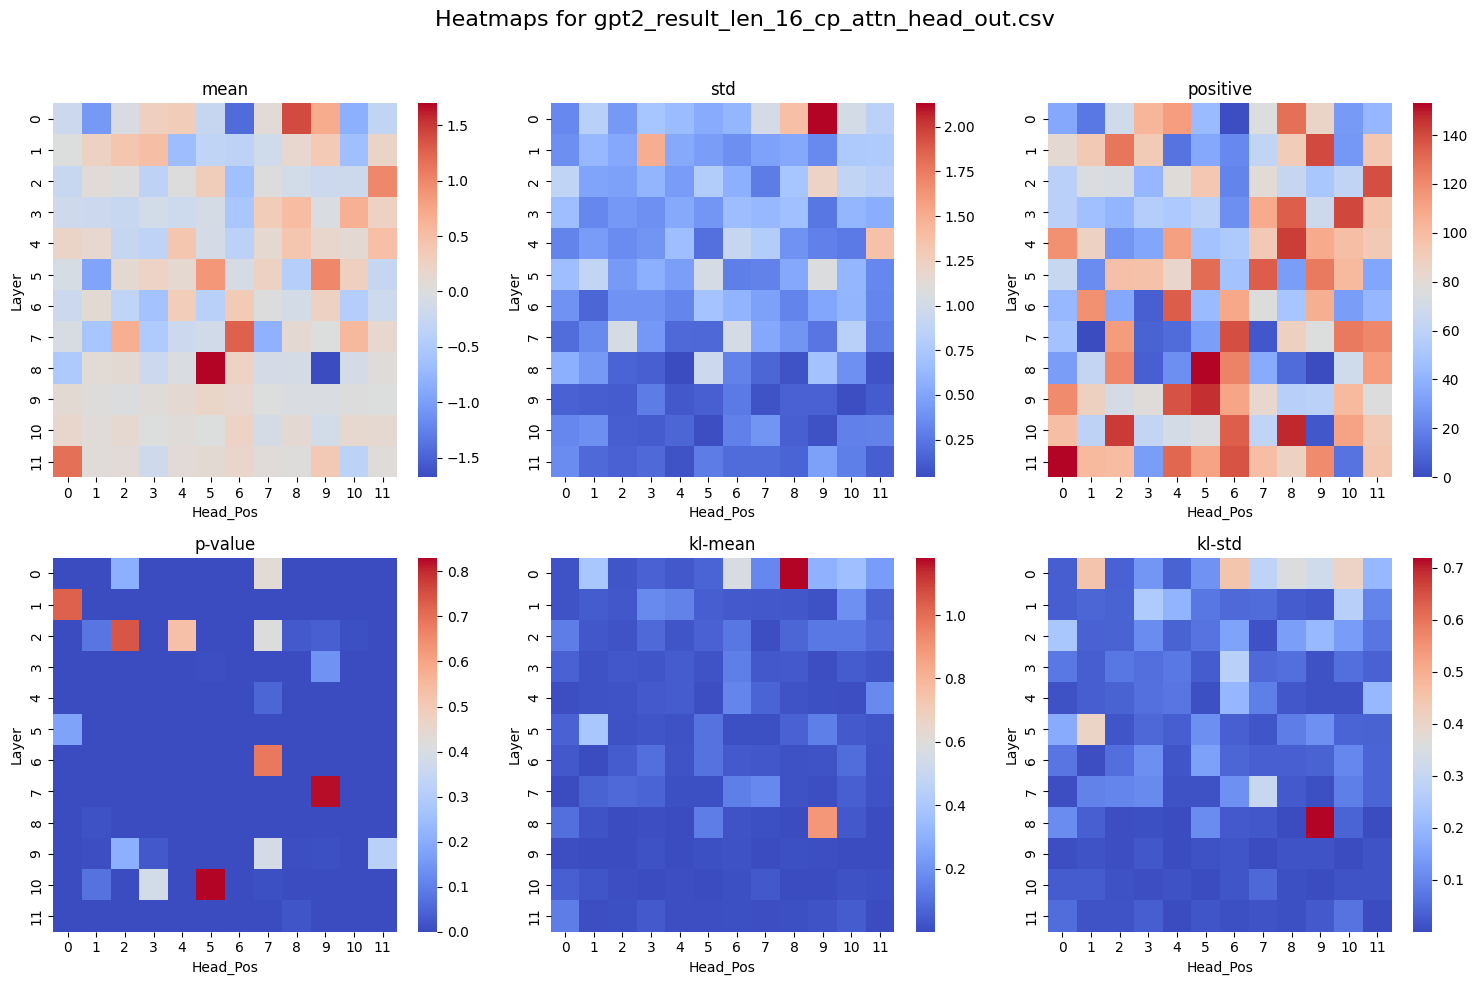

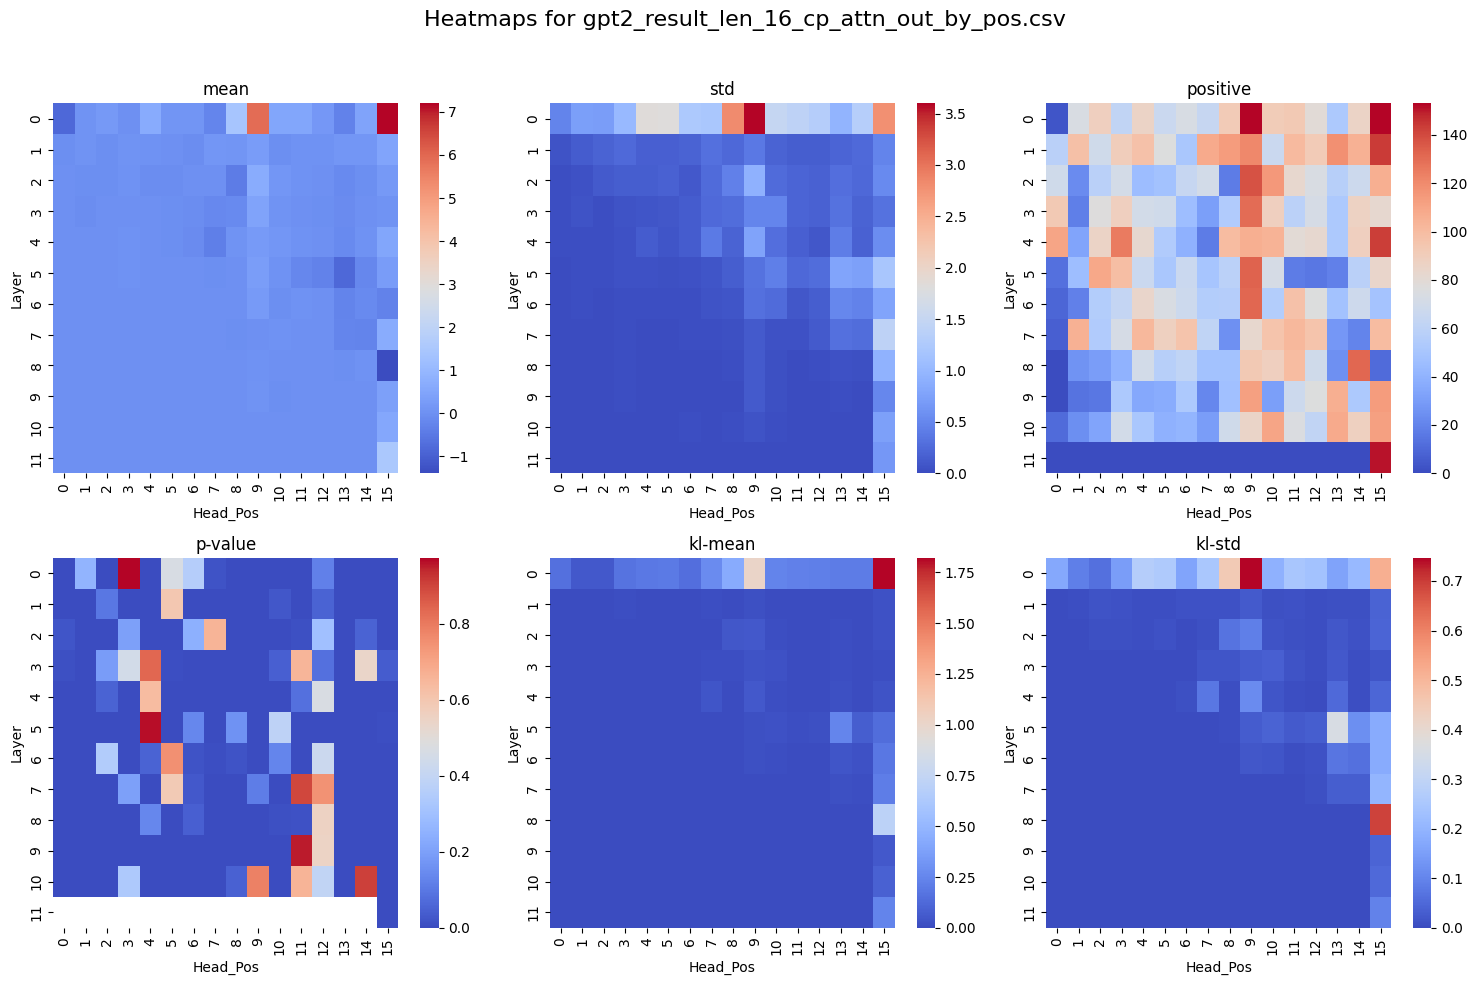

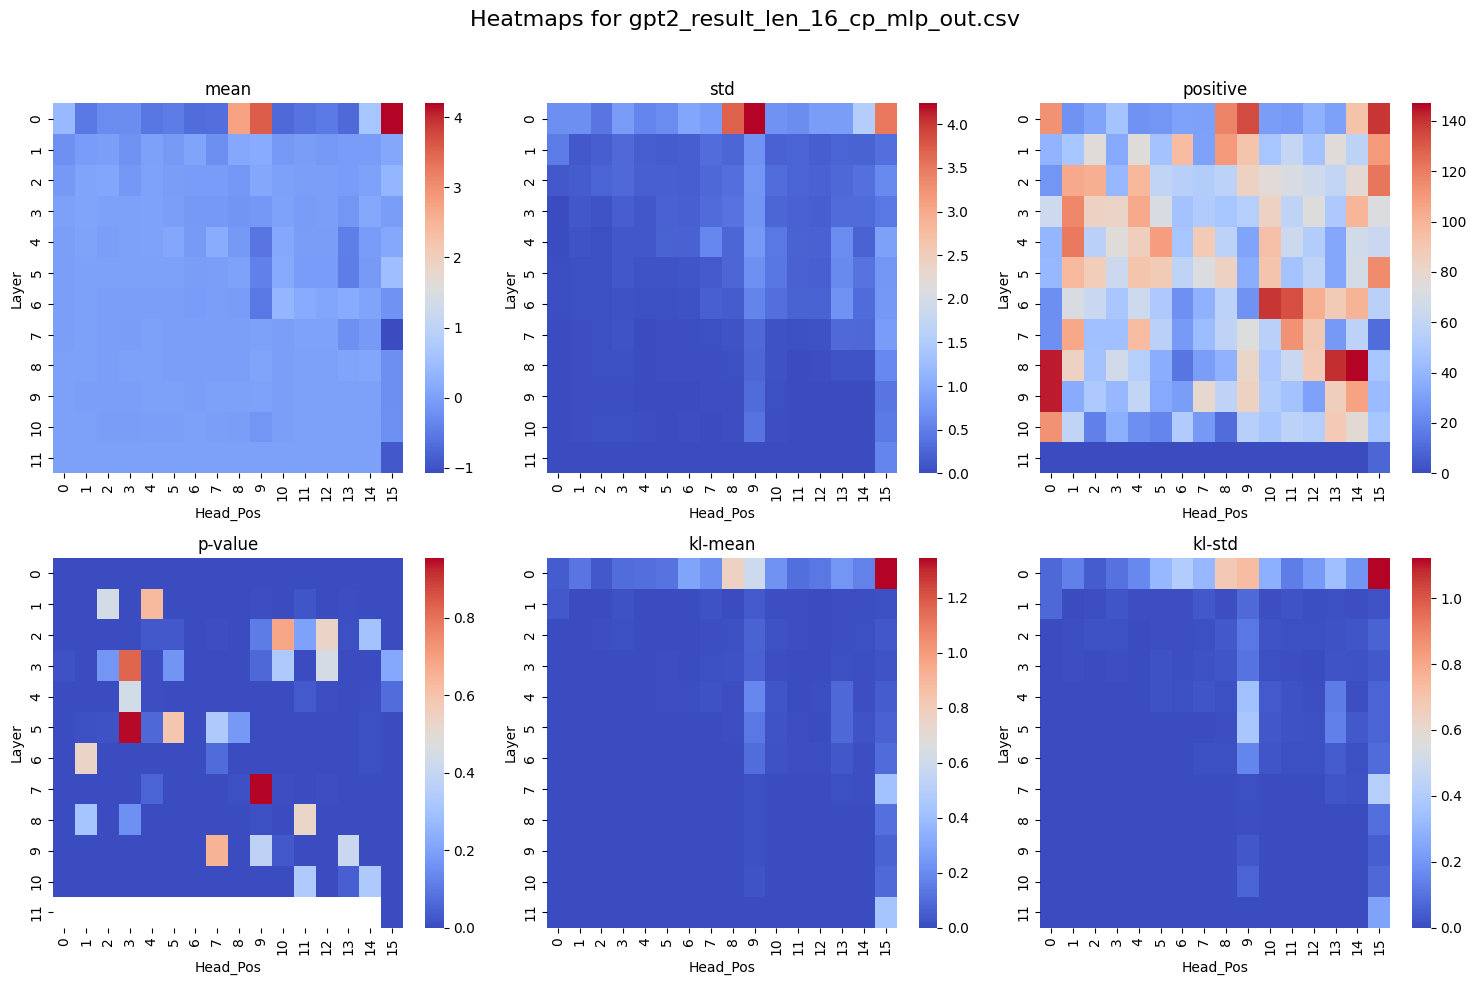

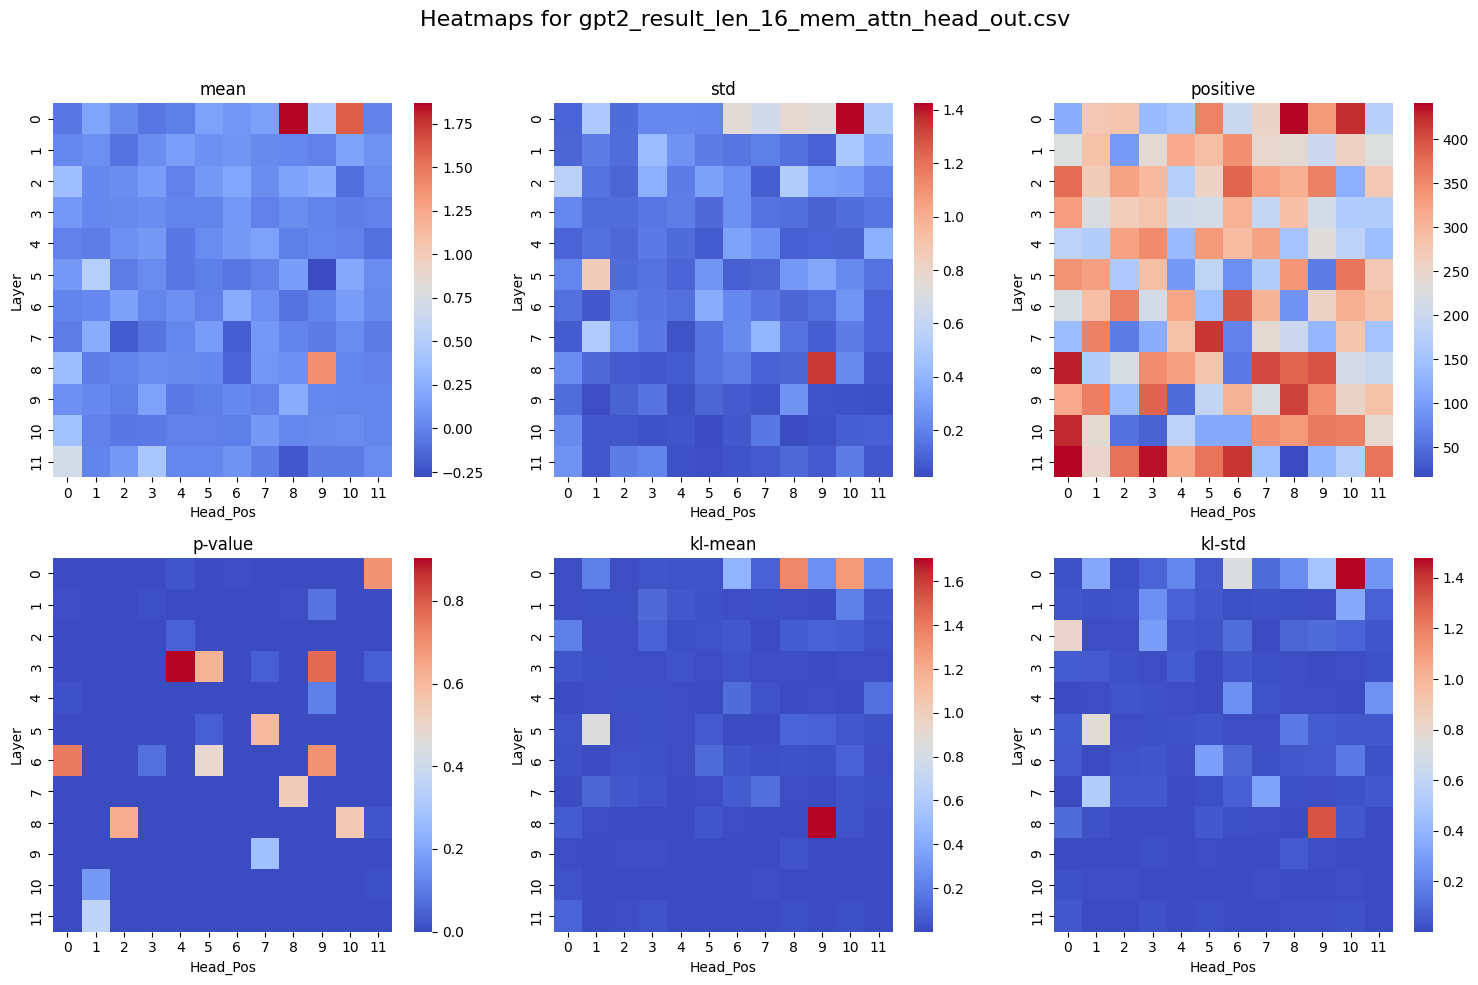

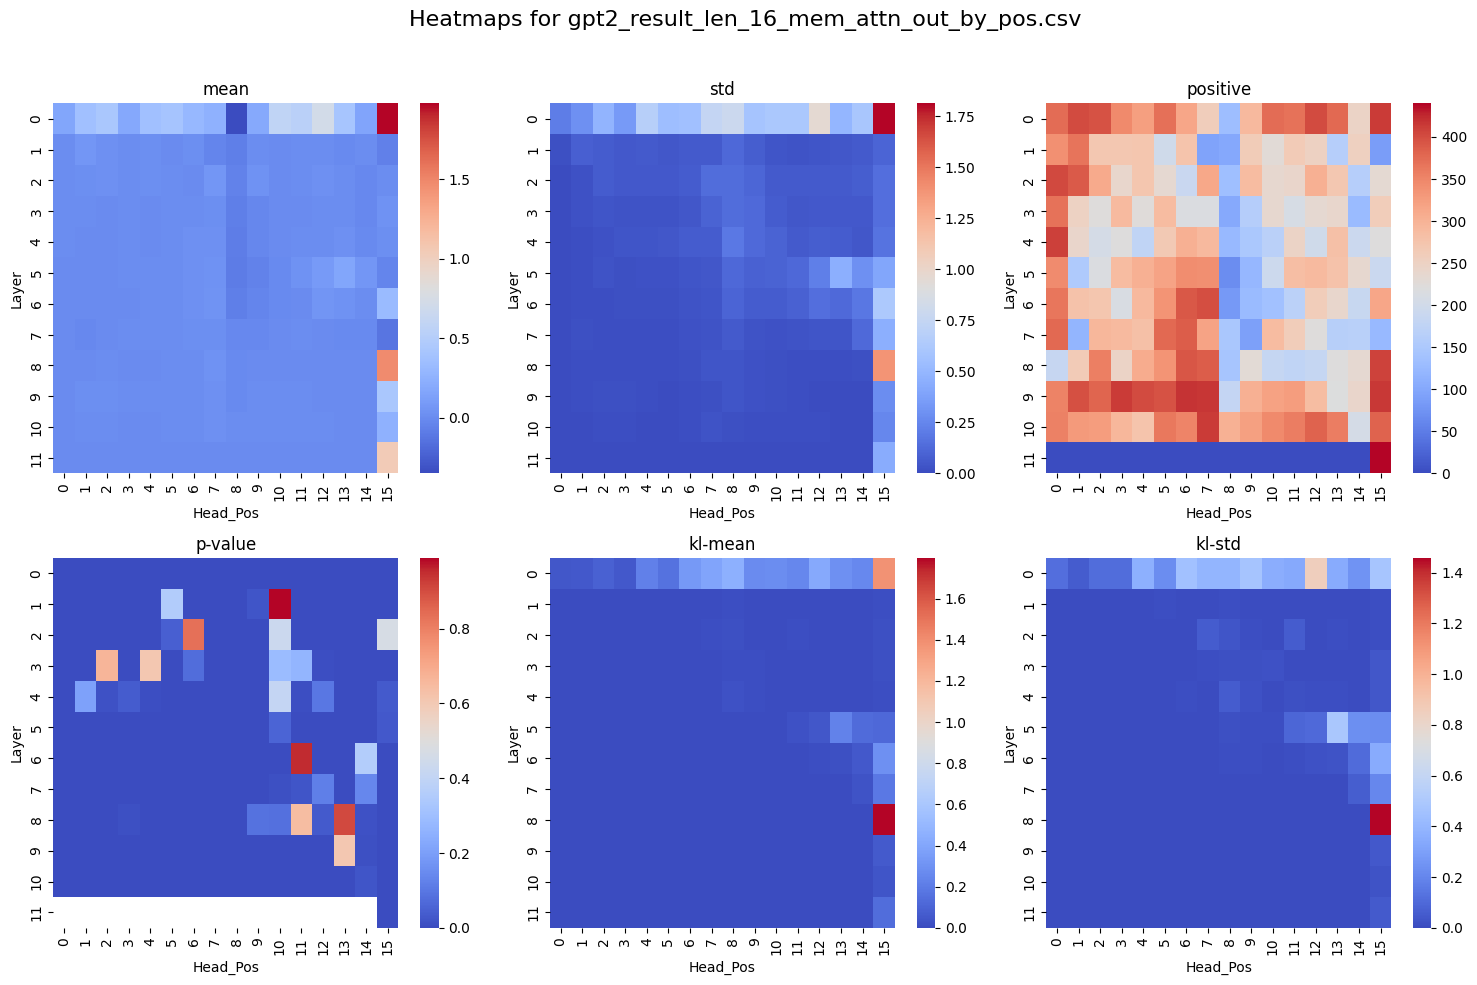

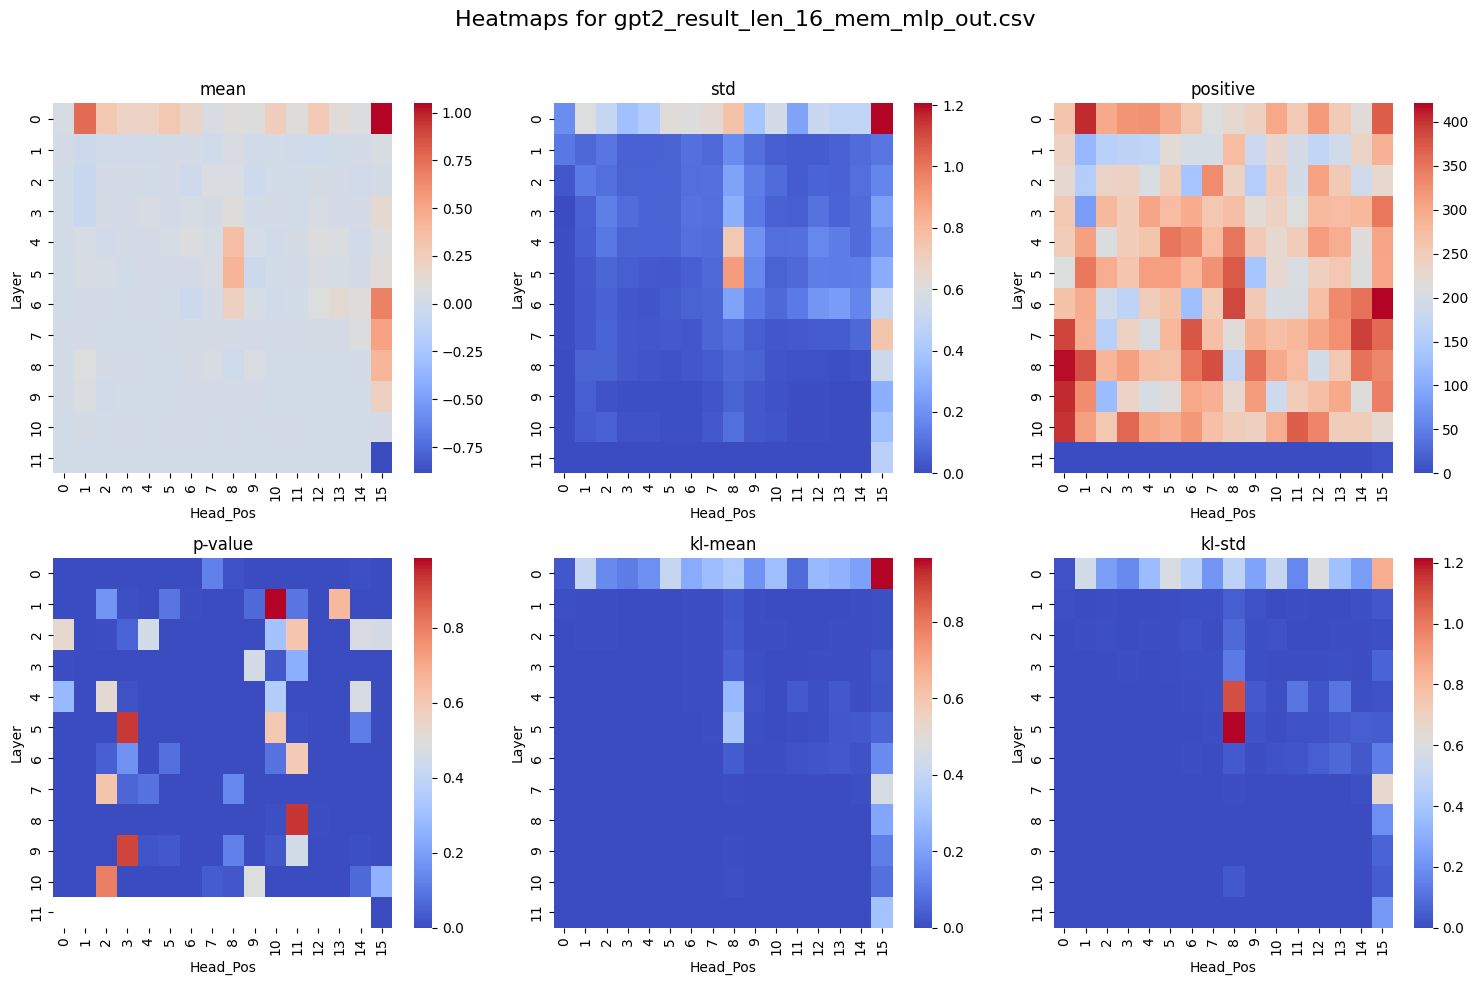

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Function to plot heatmaps for each file
def plot_heatmaps(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    df['Layer'] = df['id'].apply(lambda x: int(x.split('L')[1].split('H')[0].split('P')[0]))
    df['Head_Pos'] = df['id'].apply(lambda x: int(x.split('H')[-1]) if 'H' in x else int(x.split('P')[-1]))
    
    df = df.sort_values(by=['Layer', 'Head_Pos'])

    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Heatmaps for {os.path.basename(file_path)}", fontsize=16)
    
    # List of columns to plot
    columns_to_plot = ['mean', 'std', 'positive', 'p-value', 'kl-mean', 'kl-std']
    
    for idx, col in enumerate(columns_to_plot):
        ax = axes.flatten()[idx]
        
        # Create a pivot table for the heatmap
        pivot_df = df.pivot(index='Layer', columns='Head_Pos', values=col)

        
        # Plot the heatmap
        sns.heatmap(pivot_df, cmap='coolwarm', ax=ax, annot=False, fmt=".2f")
        ax.set_title(col)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot heatmaps for each uploaded file
for file_name in csv_files:
    file_path = os.path.join("../results/locate_mechanism/", file_name)
    plot_heatmaps(file_path)


/home/fortu/miniconda3/envs/mpi/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/fortu/miniconda3/envs/mpi/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/fortu/miniconda3/envs/mpi/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/fortu/miniconda3/envs/mpi/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/fortu/miniconda3/envs/mpi/lib/python3.11/site-packages/seaborn/_oldcore.py

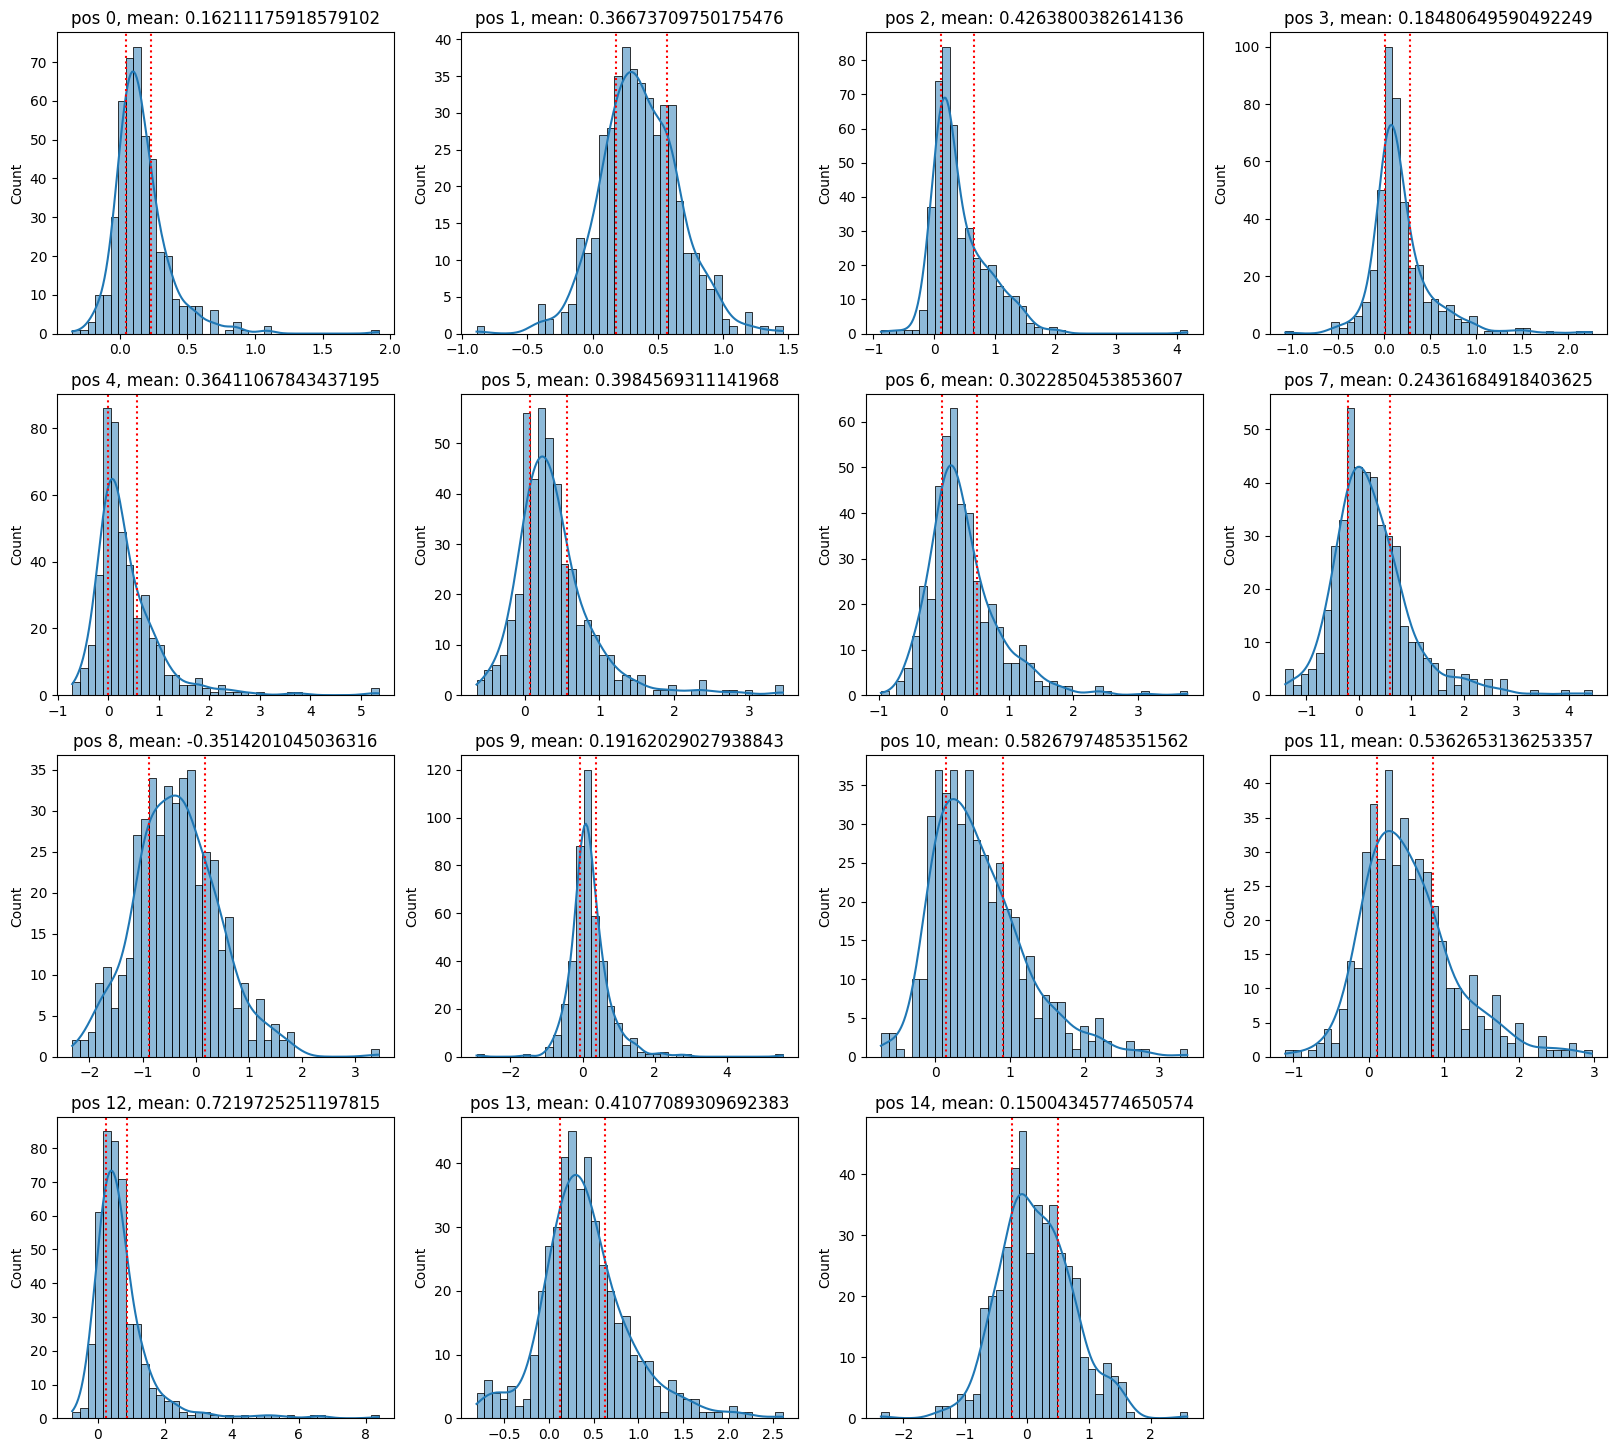

In [73]:
LAYER = 0

#plot all head of a layer in a 4x3 grid
import matplotlib.pyplot as plt

# sns.set_style("whitegrid")

plt.figure(figsize=(20,18))
for head in range(15):
    plt.subplot(4,4,head+1)
    data = result.data["mem"]["attn_out_by_pos"]["mem_delta"][:,LAYER,head]
    sns.histplot(data.detach().numpy(), bins=40, kde=True)
    #plot the median

    #plot lower and upper quartile
    plt.axvline(x=data.quantile(0.25), color='red', linestyle=':')
    plt.axvline(x=data.quantile(0.75), color='red', linestyle=':')
    plt.title(f'pos {head}, mean: {data.mean()}')  # Optionally, add title for each subplot

plt.show()



In [39]:
data_lens_mem.shape

torch.Size([100, 100])

/home/fortu/miniconda3/envs/mpi/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fortu/miniconda3/envs/mpi/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/fortu/miniconda3/envs/mpi/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fortu/miniconda3/envs/mpi/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

<Axes: >

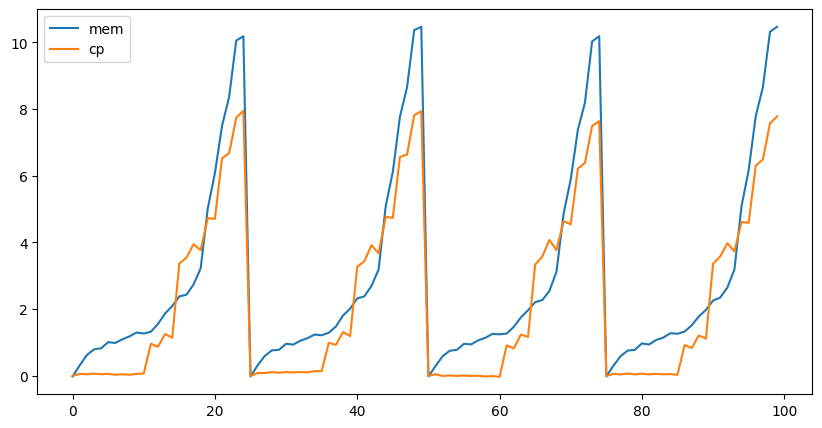

In [38]:
data_lens_mem = result.data["mem"]["logit_lens_mem"]
data_len_cp = result.data["mem"]["logit_lens_cp"]

# plot two line plot
plt.figure(figsize=(10,5))
sns.lineplot(data=data_lens_mem.detach().numpy().mean(-1), label="mem")
# plt.fill_between(range(100), data_lens_mem.detach().numpy().mean(-1) - data_lens_mem.detach().numpy().std(-1), data_lens_mem.detach().numpy().mean(-1) + data_lens_mem.detach().numpy().std(-1), alpha=0.2)
#plot the variance
sns.lineplot(data=data_len_cp.detach().numpy().mean(-1), label="cp")
# plt.fill_between(range(100), data_len_cp.detach().numpy().mean(-1) - data_len_cp.detach().numpy().std(-1), data_len_cp.detach().numpy().mean(-1) + data_len_cp.detach().numpy().std(-1), alpha=0.2)

In [254]:
torch.randint(0, 50257, (100, 1)).shape

torch.Size([100, 1])

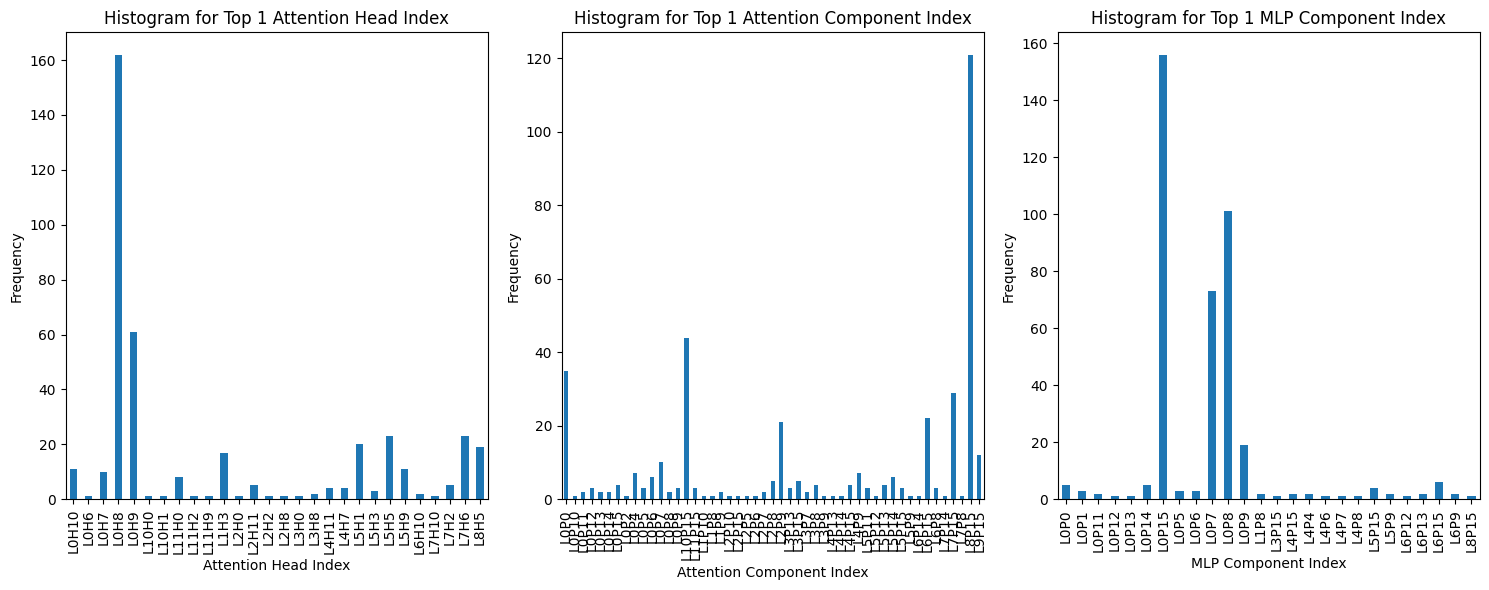

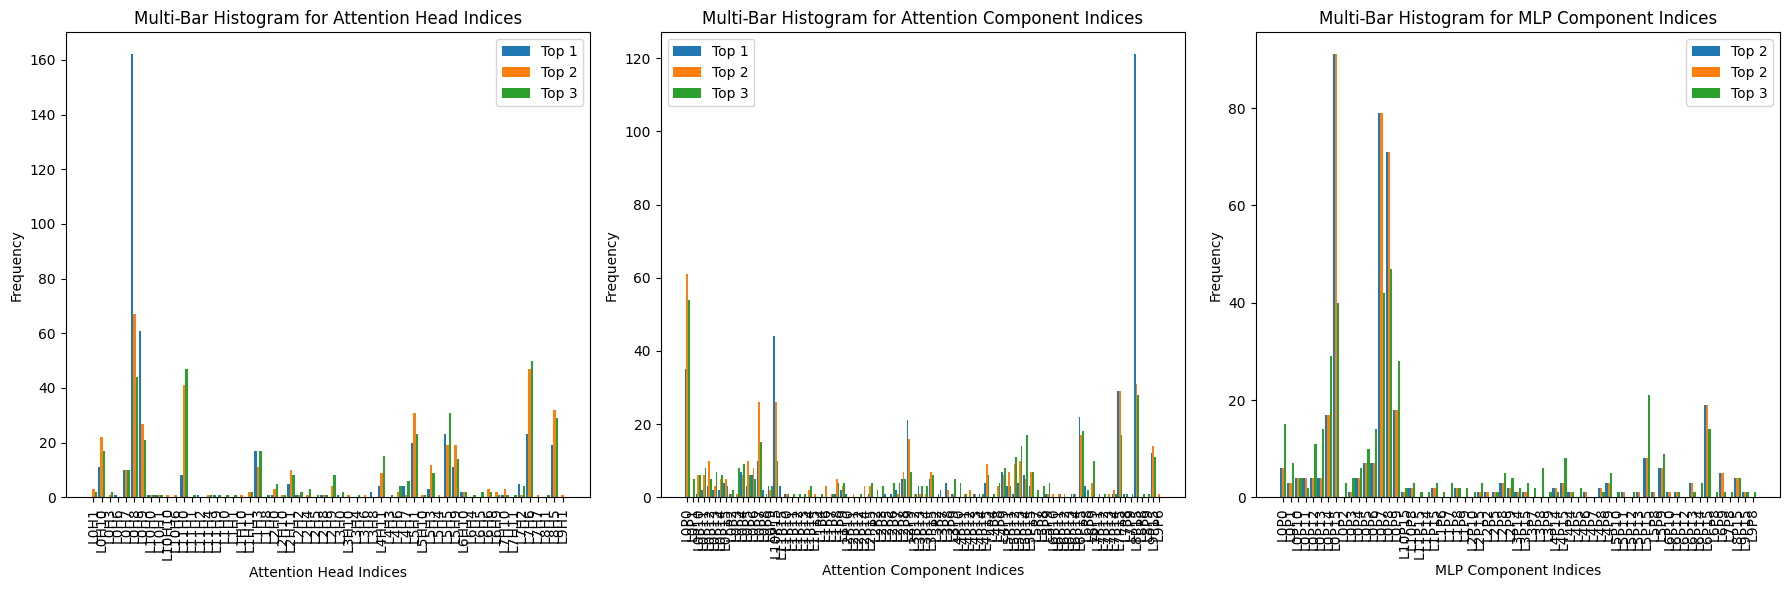

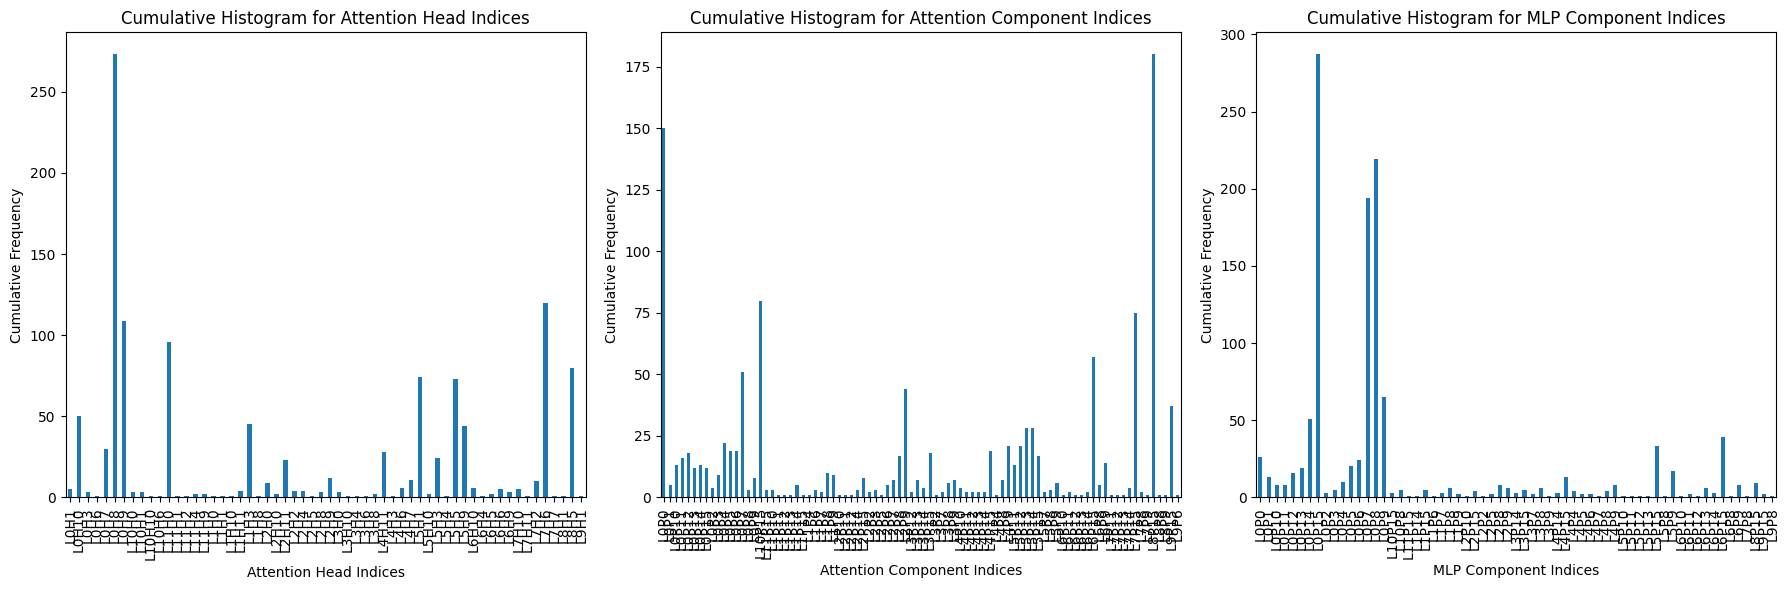

In [45]:
import numpy as np

df = pd.read_csv(f"../results/locate_mechanism/{FILE_NAME}_cp_top_component_per_prompt.csv")

import matplotlib.pyplot as plt

# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Histogram for top1_attention_head_idx
df['top1_attention_head_idx'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Histogram for Top 1 Attention Head Index')
axes[0].set_xlabel('Attention Head Index')
axes[0].set_ylabel('Frequency')

df["top1_component_attn_idx"].value_counts().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('Histogram for Top 1 Attention Component Index')
axes[1].set_xlabel('Attention Component Index')
axes[1].set_ylabel('Frequency')

# Histogram for top1_component_mlp_idx
df['top1_component_mlp_idx'].value_counts().sort_index().plot(kind='bar', ax=axes[2])
axes[2].set_title('Histogram for Top 1 MLP Component Index')
axes[2].set_xlabel('MLP Component Index')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Combine the top 3 indices for attention heads and MLP components
top3_attention_head_indices = pd.concat([df['top1_attention_head_idx'], df['top2_attention_head_idx'], df['top3_attention_head_idx']], axis=0).reset_index(drop=True)
top3_attn_out_indices = pd.concat([df['top1_component_attn_idx'], df['top2_component_attn_idx'], df['top3_component_attn_idx']], axis=0).reset_index(drop=True)
top3_mlp_indices = pd.concat([df['top1_component_mlp_idx'], df['top2_component_mlp_idx'], df['top3_component_mlp_idx']], axis=0).reset_index(drop=True)


# Count the frequencies
attention_head_counts = top3_attention_head_indices.value_counts().sort_index()
attn_out_count = top3_attn_out_indices.value_counts().sort_index()
mlp_counts = top3_mlp_indices.value_counts().sort_index()

# Prepare data for multi-bar histograms
labels = np.unique(top3_attention_head_indices)
top1_attention_counts = df['top1_attention_head_idx'].value_counts().reindex(labels, fill_value=0)
top2_attention_counts = df['top2_attention_head_idx'].value_counts().reindex(labels, fill_value=0)
top3_attention_counts = df['top3_attention_head_idx'].value_counts().reindex(labels, fill_value=0)

labels_attn = np.unique(top3_attn_out_indices)
top1_attn_counts = df['top1_component_attn_idx'].value_counts().reindex(labels_attn, fill_value=0)
top2_attn_counts = df['top2_component_attn_idx'].value_counts().reindex(labels_attn, fill_value=0)
top3_attn_counts = df['top3_component_attn_idx'].value_counts().reindex(labels_attn, fill_value=0)

labels_mlp = np.unique(top3_mlp_indices)
top1_mlp_counts = df['top1_component_mlp_idx'].value_counts().reindex(labels_mlp, fill_value=0)
top2_mlp_counts = df['top2_component_mlp_idx'].value_counts().reindex(labels_mlp, fill_value=0)
top3_mlp_counts = df['top3_component_mlp_idx'].value_counts().reindex(labels_mlp, fill_value=0)

# Create multi-bar histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Attention heads
x = np.arange(len(labels))
width = 0.3
axes[0].bar(x - width, top1_attention_counts, width, label='Top 1')
axes[0].bar(x, top2_attention_counts, width, label='Top 2')
axes[0].bar(x + width, top3_attention_counts, width, label='Top 3')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=90)
axes[0].set_title('Multi-Bar Histogram for Attention Head Indices')
axes[0].set_xlabel('Attention Head Indices')
axes[0].set_ylabel('Frequency')
axes[0].legend()

x_attn = np.arange(len(labels_attn))
axes[1].bar(x_attn - width, top1_attn_counts, width, label='Top 1')
axes[1].bar(x_attn, top2_attn_counts, width, label='Top 2')
axes[1].bar(x_attn + width, top3_attn_counts, width, label='Top 3')
axes[1].set_xticks(x_attn)
axes[1].set_xticklabels(labels_attn, rotation=90)
axes[1].set_title('Multi-Bar Histogram for Attention Component Indices')
axes[1].set_xlabel('Attention Component Indices')
axes[1].set_ylabel('Frequency')
axes[1].legend()


# MLP components
x_mlp = np.arange(len(labels_mlp))
axes[2].bar(x_mlp - width, top2_mlp_counts, width, label='Top 2')
axes[2].bar(x_mlp, top2_mlp_counts, width, label='Top 2')
axes[2].bar(x_mlp + width, top3_mlp_counts, width, label='Top 3')
axes[2].set_xticks(x_mlp)
axes[2].set_xticklabels(labels_mlp, rotation=90)
axes[2].set_title('Multi-Bar Histogram for MLP Component Indices')
axes[2].set_xlabel('MLP Component Indices')
axes[2].set_ylabel('Frequency')
axes[2].legend()

plt.tight_layout()
plt.show()

# Calculate cumulative counts for attention head indices and MLP component indices
cumulative_attention_counts = top1_attention_counts + top2_attention_counts + top3_attention_counts
cumulative_attn_out_counts = top1_attn_counts + top2_attn_counts + top3_attn_counts
cumulative_mlp_counts = top1_mlp_counts + top2_mlp_counts + top3_mlp_counts

# Create cumulative histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Cumulative histogram for attention head indices
cumulative_attention_counts.sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Cumulative Histogram for Attention Head Indices')
axes[0].set_xlabel('Attention Head Indices')
axes[0].set_ylabel('Cumulative Frequency')

cumulative_attn_out_counts.sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('Cumulative Histogram for Attention Component Indices')
axes[1].set_xlabel('Attention Component Indices')
axes[1].set_ylabel('Cumulative Frequency')

# Cumulative histogram for MLP component indices
cumulative_mlp_counts.sort_index().plot(kind='bar', ax=axes[2])
axes[2].set_title('Cumulative Histogram for MLP Component Indices')
axes[2].set_xlabel('MLP Component Indices')
axes[2].set_ylabel('Cumulative Frequency')

plt.tight_layout()
plt.show()


In [112]:
LAYER = 8
HEAD = 5

# search
print( "mean:", result.data["cp"]["attn_head_out"]["mean"][0,LAYER,HEAD])
print( "std:", result.data["cp"]["attn_head_out"]["std"][0,LAYER,HEAD])
print( "p-value:", result.data["cp"]["attn_head_out"]["p-value"][0,LAYER,HEAD])

mean: tensor(0.0230)
std: tensor(0.0382)
p-value: tensor(3.1890e-08)


## MEM

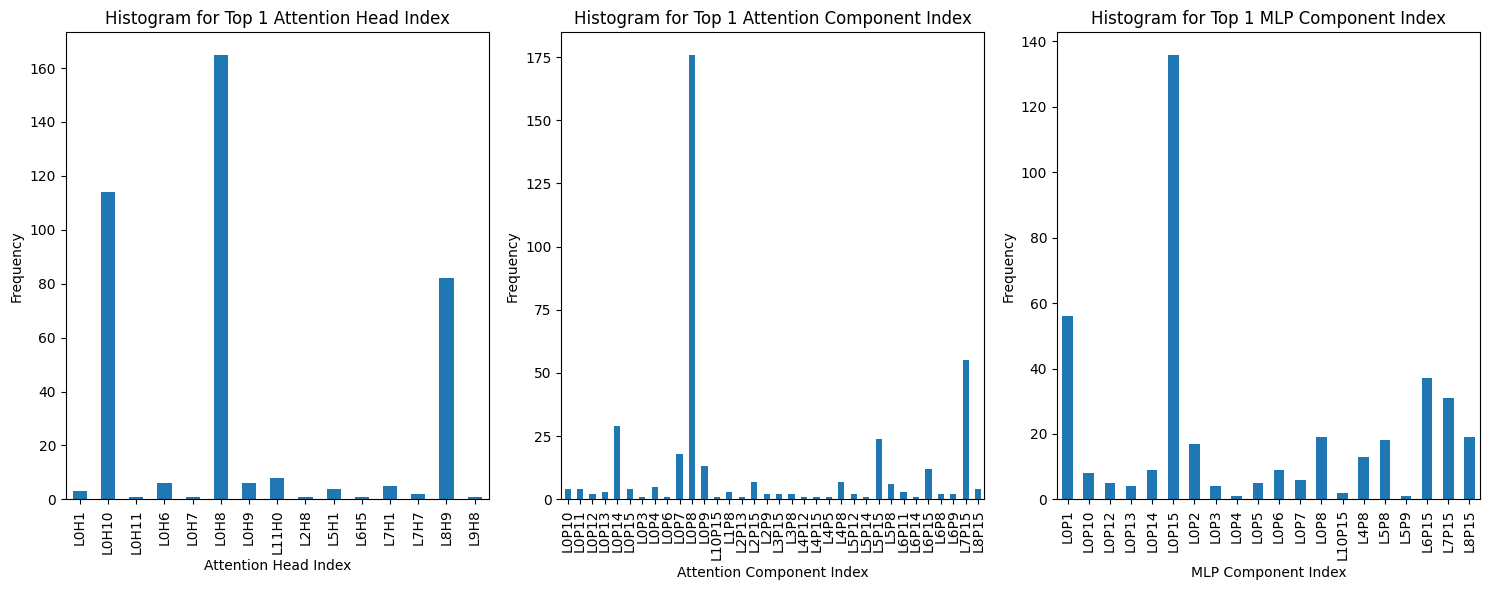

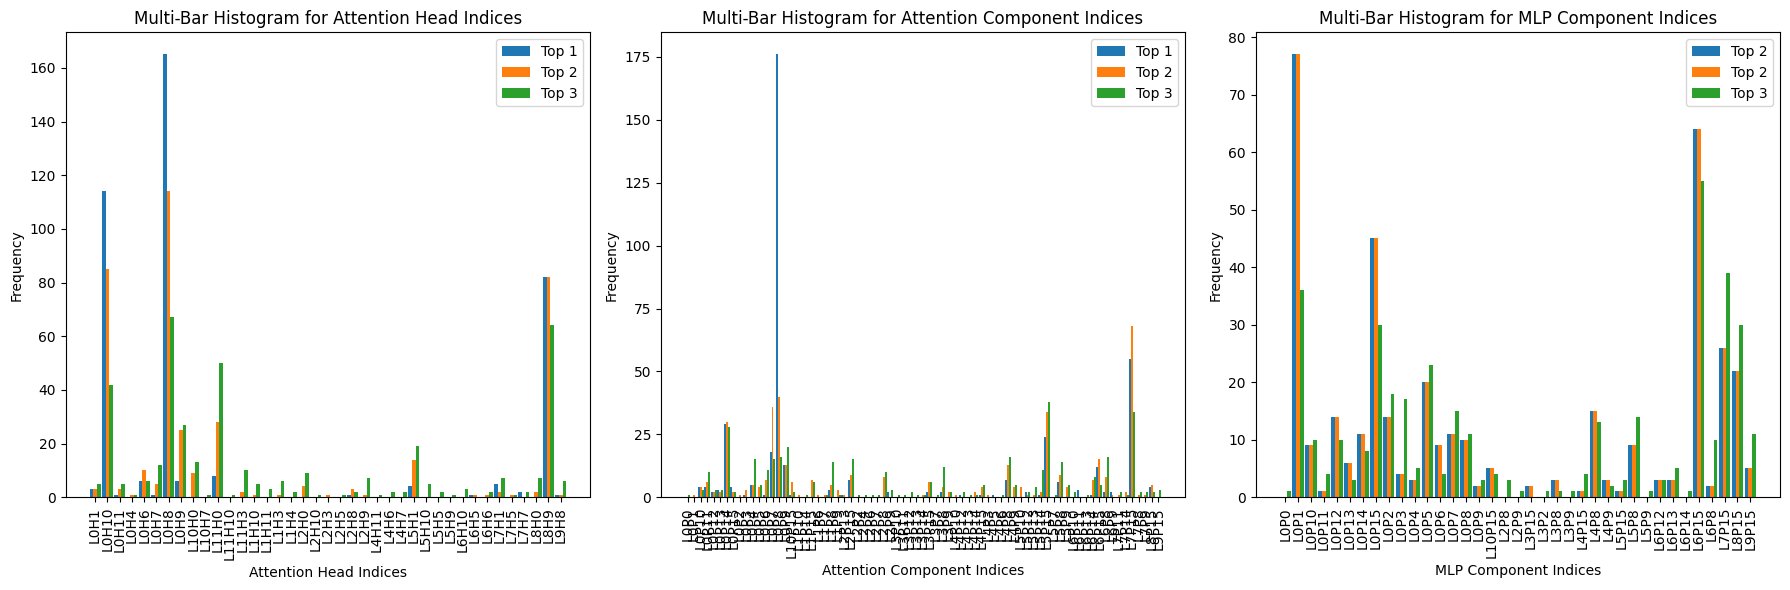

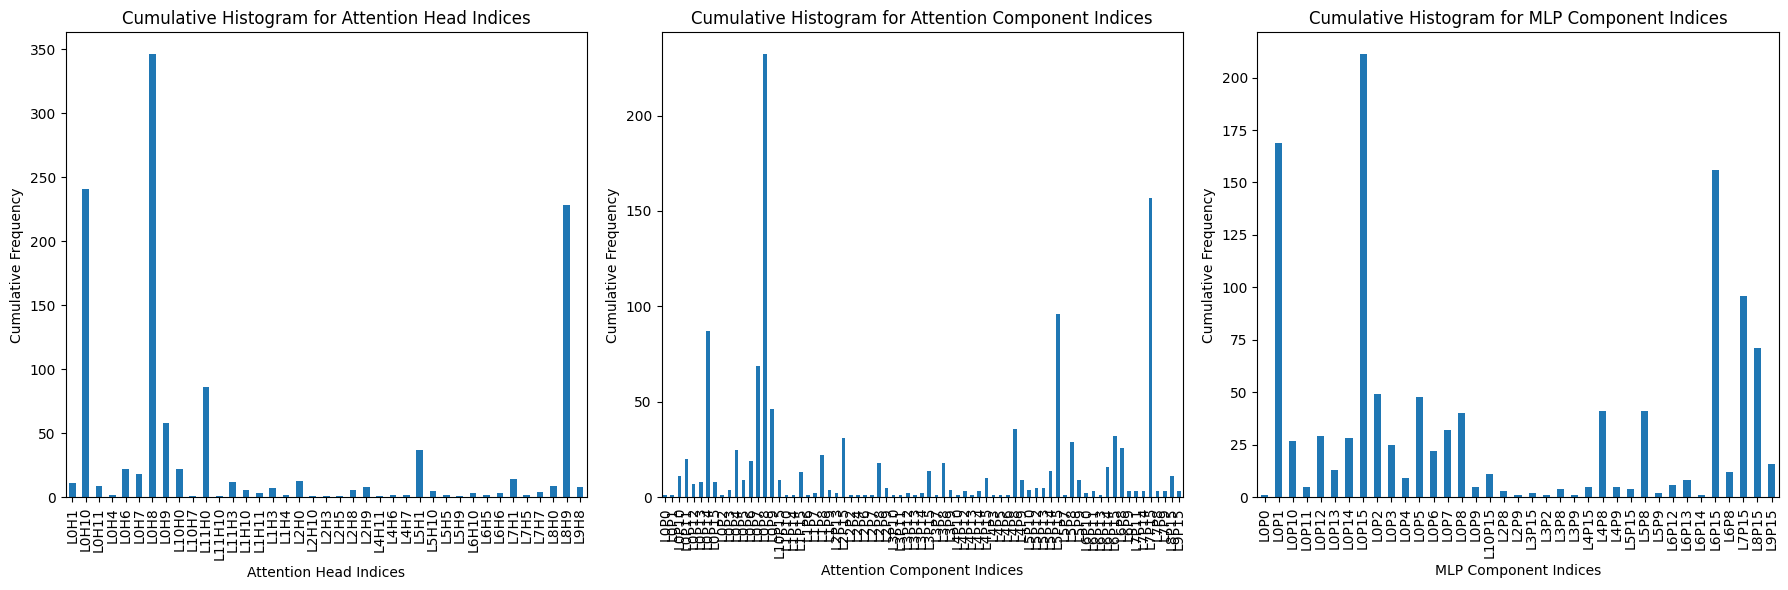

In [46]:
df = pd.read_csv(f"../results/locate_mechanism/{FILE_NAME}_mem_top_component_per_prompt.csv")

import matplotlib.pyplot as plt

# Create histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Histogram for top1_attention_head_idx
df['top1_attention_head_idx'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Histogram for Top 1 Attention Head Index')
axes[0].set_xlabel('Attention Head Index')
axes[0].set_ylabel('Frequency')

df["top1_component_attn_idx"].value_counts().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('Histogram for Top 1 Attention Component Index')
axes[1].set_xlabel('Attention Component Index')
axes[1].set_ylabel('Frequency')

# Histogram for top1_component_mlp_idx
df['top1_component_mlp_idx'].value_counts().sort_index().plot(kind='bar', ax=axes[2])
axes[2].set_title('Histogram for Top 1 MLP Component Index')
axes[2].set_xlabel('MLP Component Index')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Combine the top 3 indices for attention heads and MLP components
top3_attention_head_indices = pd.concat([df['top1_attention_head_idx'], df['top2_attention_head_idx'], df['top3_attention_head_idx']], axis=0).reset_index(drop=True)
top3_attn_out_indices = pd.concat([df['top1_component_attn_idx'], df['top2_component_attn_idx'], df['top3_component_attn_idx']], axis=0).reset_index(drop=True)
top3_mlp_indices = pd.concat([df['top1_component_mlp_idx'], df['top2_component_mlp_idx'], df['top3_component_mlp_idx']], axis=0).reset_index(drop=True)


# Count the frequencies
attention_head_counts = top3_attention_head_indices.value_counts().sort_index()
attn_out_count = top3_attn_out_indices.value_counts().sort_index()
mlp_counts = top3_mlp_indices.value_counts().sort_index()

# Prepare data for multi-bar histograms
labels = np.unique(top3_attention_head_indices)
top1_attention_counts = df['top1_attention_head_idx'].value_counts().reindex(labels, fill_value=0)
top2_attention_counts = df['top2_attention_head_idx'].value_counts().reindex(labels, fill_value=0)
top3_attention_counts = df['top3_attention_head_idx'].value_counts().reindex(labels, fill_value=0)

labels_attn = np.unique(top3_attn_out_indices)
top1_attn_counts = df['top1_component_attn_idx'].value_counts().reindex(labels_attn, fill_value=0)
top2_attn_counts = df['top2_component_attn_idx'].value_counts().reindex(labels_attn, fill_value=0)
top3_attn_counts = df['top3_component_attn_idx'].value_counts().reindex(labels_attn, fill_value=0)

labels_mlp = np.unique(top3_mlp_indices)
top1_mlp_counts = df['top1_component_mlp_idx'].value_counts().reindex(labels_mlp, fill_value=0)
top2_mlp_counts = df['top2_component_mlp_idx'].value_counts().reindex(labels_mlp, fill_value=0)
top3_mlp_counts = df['top3_component_mlp_idx'].value_counts().reindex(labels_mlp, fill_value=0)

# Create multi-bar histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Attention heads
x = np.arange(len(labels))
width = 0.3
axes[0].bar(x - width, top1_attention_counts, width, label='Top 1')
axes[0].bar(x, top2_attention_counts, width, label='Top 2')
axes[0].bar(x + width, top3_attention_counts, width, label='Top 3')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=90)
axes[0].set_title('Multi-Bar Histogram for Attention Head Indices')
axes[0].set_xlabel('Attention Head Indices')
axes[0].set_ylabel('Frequency')
axes[0].legend()

x_attn = np.arange(len(labels_attn))
axes[1].bar(x_attn - width, top1_attn_counts, width, label='Top 1')
axes[1].bar(x_attn, top2_attn_counts, width, label='Top 2')
axes[1].bar(x_attn + width, top3_attn_counts, width, label='Top 3')
axes[1].set_xticks(x_attn)
axes[1].set_xticklabels(labels_attn, rotation=90)
axes[1].set_title('Multi-Bar Histogram for Attention Component Indices')
axes[1].set_xlabel('Attention Component Indices')
axes[1].set_ylabel('Frequency')
axes[1].legend()


# MLP components
x_mlp = np.arange(len(labels_mlp))
axes[2].bar(x_mlp - width, top2_mlp_counts, width, label='Top 2')
axes[2].bar(x_mlp, top2_mlp_counts, width, label='Top 2')
axes[2].bar(x_mlp + width, top3_mlp_counts, width, label='Top 3')
axes[2].set_xticks(x_mlp)
axes[2].set_xticklabels(labels_mlp, rotation=90)
axes[2].set_title('Multi-Bar Histogram for MLP Component Indices')
axes[2].set_xlabel('MLP Component Indices')
axes[2].set_ylabel('Frequency')
axes[2].legend()

plt.tight_layout()
plt.show()

# Calculate cumulative counts for attention head indices and MLP component indices
cumulative_attention_counts = top1_attention_counts + top2_attention_counts + top3_attention_counts
cumulative_attn_out_counts = top1_attn_counts + top2_attn_counts + top3_attn_counts
cumulative_mlp_counts = top1_mlp_counts + top2_mlp_counts + top3_mlp_counts

# Create cumulative histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Cumulative histogram for attention head indices
cumulative_attention_counts.sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Cumulative Histogram for Attention Head Indices')
axes[0].set_xlabel('Attention Head Indices')
axes[0].set_ylabel('Cumulative Frequency')

cumulative_attn_out_counts.sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('Cumulative Histogram for Attention Component Indices')
axes[1].set_xlabel('Attention Component Indices')
axes[1].set_ylabel('Cumulative Frequency')

# Cumulative histogram for MLP component indices
cumulative_mlp_counts.sort_index().plot(kind='bar', ax=axes[2])
axes[2].set_title('Cumulative Histogram for MLP Component Indices')
axes[2].set_xlabel('MLP Component Indices')
axes[2].set_ylabel('Cumulative Frequency')

plt.tight_layout()
plt.show()

